# Example Burgers' equation

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.style.use('seaborn-notebook')

# DeepMoD stuff
from deepymod_torch.DeepMod import DeepMod
from deepymod_torch.library_functions import library_basic
from deepymod_torch.utilities import create_deriv_data, terms_definition

# Setting cuda if GPU is available
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)

Next, we prepare the dataset.

In [16]:
data = np.load('data/burgers.npy', allow_pickle=True).item()
print('Shape of grid:', data['x'].shape)

Shape of grid: (256, 101)


Let's plot it to get an idea of the data:

In [17]:
fig, ax = plt.subplots()
im = ax.contourf(data['x'], data['t'], np.real(data['u']))
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAecAAAFfCAYAAAB0lARMAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjEsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8QZhcZAAAgAElEQVR4nO3df7BkZZ3f8c/HGS8IywgWgs4PBckoO2sECQwmxF0RMYMaRxOzgZSKPzYWWXHV2s3uqJV4Kf9YFXdXdkOcdZFFKyplgaNTOuFHcJXalBBAZ4FxhjjOssz1oqNBGVcD14Fv/ugzm6bpvn1O9/nxnNPvV9Wtud19nttPUcN87vN9vv0cR4QAAEA6ntL0BAAAwBMRzgAAJIZwBgAgMYQzAACJIZwBAEgM4QwAQGIqC2fbV9s+YPvevueeYftm29/N/jyuqvcHACCPYXk18Lpt/6ntvbbvtn1G32v3277H9k7bd5Y1pypXztdI2jTw3BZJt0TEekm3ZI8BAGjSNXpyXvW7QNL67Osdkj4x8Pq5EXF6RJxZ1oQqC+eIuFXSQwNPb5b06ez7T0t6XVXvDwBAHiPyqt9mSZ+JntskHWv72VXOaWWVP3yIEyPiQUmKiAdtn5BnkO15SR+UpKc85ak6+qhcw9Axjx3ppqcwkcfmmp5B9VYsFbz+EU4m7JKf/f33fxwRzyz75770ZUfGTx56fKKxu+755fckndL31GURMT/hVNZI2t/3eCF77kFJIekm2yHpzyPikxO+xxPUHc4Tyf6DzkvSqmPWxllnvrPR+aAZD59yRNNTmMjPntvOXyqKOObvioXt07/3aEUzQRO+9vX3/10VP/cnDz2u6796/ERjT33Ogz+NiLL+5xv2cw7/pT8nIhazxebNtvdkK/Gp1N2t/cPDpYDszwM1vz9Qq1kI5qIIZrTQgqR1fY/XSlqUpIg4/OcBSdskbSzjDesO5+2SLs6+v1jSl2t+fwAAitou6c1Z1/ZLJD2cbc0ebfsYSbJ9tKRXShra8V1UZWVt25+X9DJJx9teUG/P+MOSvmD77ZIekPRvqnp/AADyGJFXT5WkiNgqaYekV0naK+kXkt6aDT1R0jbbUi9PPxcRN5Qxp8rCOSIuGvHSeVW9J7qrrfvNANK3TF4dfj0kPanZKSL2STqtijlxQhhQkVnZby7aDAZgPMIZAIDEEM4AakOnNpAP4QwAQGIIZwAAEkM4AxWYlWYwANUgnAEASAzhDGBiRT5GRTMYkB/hDABAYghnJK9tp4Ox3wxgWoQzAACJIZwBAEgM4QwAQGIIZwCVo1MbKIZwBko0S81g3I0KqA7hDABAYghnAAASQzgDAJAYwhkoySztNxdBMxhQHOGMpLXtdDAAKAPhDABAYghnAIXxMSqgWoQzAACJIZyBEtAMBqBMhDOAytCpDUyGcAYAIDGEMwAAiSGcgSnN2n4zndpA9QhnAAASQzgjWZwO1m40g6FNbG+yfZ/tvba3DHn9ONvbbN9t+3/ZfmHesZMgnAEAM832CklXSrpA0gZJF9neMHDZ+yXtjIgXSXqzpCsKjC2McAYAzLqNkvZGxL6IWJJ0raTNA9dskHSLJEXEHkkn2T4x59jCVk77A4BZNmvNYECdfvLYUbru4BkTjv7qatv93YuXRcT8iIvXSNrf93hB0tkD1/yNpH8l6a9tb5T0XElrc44tjHAGAHTRYkSsznntsN+yBz+W8GFJV9jeKekeSd+WdCjn2MIIZwC55f0YFc1gaJkFSev6Hq+VtNh/QUQclPRWSbJtSX+bfR01buwk2HMGAMy6OyStt32y7TlJF0ra3n+B7WOz1yTptyTdmgX22LGTYOUMTIj9ZqAbIuKQ7Usl3ShphaSrI2KX7Uuy17dK+lVJn7H9mKTvSHr7cmOnnRPhDACYeRGxQ9KOgee29n3/TUnr846dFmVtAAASQzgjSZwO1l40gwHTI5wB5MINL4D6EM7ABGgGA1AlwhkAgMQQzgAAJIZwBgAgMYQzUBD7zaPRqQ2Ug3AGMBad2kC9CGcAABJDOAMAkBjCGcnhdDAAs45wBgqgGWw0msGA8jQSzrbfa3uX7Xttf972kU3MAwCAFNUezrbXSPodSWdGxAvVu//lhXXPA0A+dGoD9WuqrL1S0tNsr5R0lKTFhuYBAEByag/niPi+pI9JekDSg5Iejoiblhtje9522I5Hlw7WMU3gSdhvBlCXJsrax0naLOlkSaslHW37jcuNiYj5iHBE+Ii5VXVME0ABNIMB5WqirP0KSX8bET+KiF9K+qKkf9bAPAAASFIT4fyApJfYPsq2JZ0naXcD8wAAIElN7DnfLuk6Sd+SdE82h0/WPQ8A49GpDTRjZRNvGhEflPTBJt4bmATNYADqxAlhSApHd7YPzWBA+QhnAAASQzgDAJAYwhkYg/1mAHUjnIGOePQ5S6X+PDq1geY00q0NoDz9oXz4+yMemKvlvWkGA6rByhlosbJXy8Cssr3J9n2299reMuT1/2h7Z/Z1r+3HbD8je+1+2/dkr91ZxnwIZ6CllgtmQhvIz/YKSVdKukDSBkkX2d7Qf01EXB4Rp0fE6ZLeJ+kbEfFQ3yXnZq+fWcacCGdgGTSDATNho6S9EbEvIpYkXaveDZpGuUjS56ucEOEMtBArY2Cs1YdvNZx9zS9z7RpJ+/seL2TPPYntoyRtknR939Mh6Sbbd9l+x5TzlkRDGBLC6WD51BHMeTq1aQZD1Q4eOlI3/+DUCUd/dTEiVue8eFiJbNT/BP9S0v8cKGmfExGLtk+QdLPtPRFxa5HZDmLlDACYdQuS1vU9XitpccS1F2qgpB0Ri9mfByRtU69MPhXCGRghxf1mytlAJe6QtN72ybbn1Avg7YMX2X66pN+Q9OW+5462fczh7yW9UtK9006IsjYAYKZFxCHbl0q6UdIKSVdHxC7bl2Svb80ufb2kmyLi533DT5S0zbbUy9TPRcQN086JcAZaouiq+dHnLNV2GAnQdhGxQ9KOgee2Djy+RtI1A8/tk3Ra2fOhrA2gMJrBgGoRzkAL1LnXzJnaQPMIZ2CIFJvBAMwOwhlIHB3awOwhnAEUwn4zUD3CGUngdLDhWDUDs4lwBgaw3wygaYQzkKgmVs10agNpIJwBAEgM4QwkKNW9ZprBgHoQzgAAJIZwBvqk0AyW6qoZQH0IZwCSaAYDUkI4AwCQGMIZSEiZJe2ybxdJMxhQH8IZyKSw3wwAEuGMBHB0Zw+NYAAOI5wB0AwGJIZwBgAgMYQzkIDUS9o0gwH1IpwB0QwGIC2EM9Cw1FfNAOpHOAMAkBjCGZhx4zq12W8G6kc4Y+Y1ud9MSRvAMIQzAACJIZzRqFk+HYxVM4BRCGcAABJDOAMdlPeOVDSDAT22N9m+z/Ze21tGXPMy2ztt77L9jSJji1pZxg8B2qqpZjBK2kA6bK+QdKWk8yUtSLrD9vaI+E7fNcdK+q+SNkXEA7ZPyDt2EqycAQCzbqOkvRGxLyKWJF0rafPANf9O0hcj4gFJiogDBcYWRjgDNWPVDNRite3o+5pf5to1kvb3PV7Inuv3fEnH2f667btsv7nA2MIoawMYiv1mNG1paaXuX3jmpMMXI2J1zmuH7W8NNmSslPRPJJ0n6WmSvmn7tpxjCyOcMbNm/WYX3MMZ+AcLktb1PV4raXHINT+OiJ9L+rntWyWdlnNsYZS1gRpR0gaSdIek9bZPtj0n6UJJ2weu+bKkl9peafsoSWdL2p1zbGGsnAEAMy0iDtm+VNKNklZIujoidtm+JHt9a0Tstn2DpLslPS7pqoi4V5KGjZ12To2Ec9aSfpWkF6pXm39bRHyzibkAABAROyTtGHhu68DjyyVdnmfstJpaOV8h6YaIeENWBjiqoXmgQbN2dGebSto0gwHNqj2cba+S9OuS3iJJ2efC2vOvFjqhy81geU4HoxkMSFsTDWHPk/QjSX9p+9u2r7J99HIDbM8f/qzao0sH65klUKI2rZoBNK+JcF4p6QxJn4iIF0v6uaRlzyKNiPmIcET4iLlVdcwRAIDGNBHOC5IWIuL27PF16oU1gASw3ww0r/ZwjogfSNpv+wXZU+dJmuqAcKCIuvebKWkDKKqpbu13Sfps1qm9T9JbG5oHMHNoBgPS10g4R8ROSWc28d4AAKSO4zuBCrWtpM1+M5AGwhnokDyfcQaQPsIZM6XLh48A6A7CGY2YhaM7Uyxp0wwGtAPhDABAYghnoAIprprHoRkMSAfhDABAYghnzAyawQC0BeEMlKypkva4j1HRDAa0B+EMgP1mIDGEMwAAiSGcMRPq2m9uY5c2gPQQzgAAJIZwBmbAcs1g7DcD6SGcUbuuHt1JSRtAWQhnoAO4GxXQLYQzOq+OZjBWzQDKRDgDM4z9ZiBNhDPQcZwMBrQP4QxMiZI2gLIRzug0bnYBoI0IZwDAzLO9yfZ9tvfa3rLMdWfZfsz2G/qeu9/2PbZ32r6zjPmsLOOHALMqhZL2ch+j4vARYDzbKyRdKel8SQuS7rC9PSK+M+S6j0i6cciPOTciflzWnMaunG2vyvMcAAAttVHS3ojYFxFLkq6VtHnIde+SdL2kA1VPKM/K+euSzsjxHAAApfGSpzlgZ7Xt/tLRZRExP+LaNZL29z1ekHT2E+Zir5H0ekkvl3TWwPiQdFP2fn8eEZ+cdNKHjQxn2yslzUl6iu2nSTrcWfN0SUdN+8aYTXUe3Vl1M1gKJW0AIy1GxOqc1w77x2JwT+jjkv4gIh6zn3T5ORGxaPsESTfb3hMRtxac7xMst3L+gKQPZhP8ed/zByX90TRvCqBZ7DcDT7AgaV3f47WSFgeuOVPStVkwHy/pVbYPRcSXImJRkiLigO1t6pXJpwrnkXvOEXFZRDxF0ici4il9X8dGxIemeVMA1ePwESC3OyStt32y7TlJF0ra3n9BRJwcESdFxEmSrpP02xHxJdtH2z5GkmwfLemVku6ddkJj95wj4tJp3wTomlRK2tzwApheRByyfal6XdgrJF0dEbtsX5K9vnWZ4SdK2patqFdK+lxE3DDtnPgoFQBg5kXEDkk7Bp4bGsoR8Za+7/dJOq3s+XAICTqJk8FGY78ZSB/hDBSUSkl7Oew3A+1GOAMAkBjCGQCAxBDO6Jwq95tTKmlP0qnNfjPQDoQzAACJIZxRmzqP7qxCSqvm5dAMBrQf4QwAQGIIZ2BGsN8MtAfhjE6pqhkstZI2x3YC3UY4Ax3CfjPQDYQzMAMoaQPtQjgDY6RW0gbQfYQzOoObXQDoCsIZaJlRzWDsN7fP3J6FpqeARBHOwDK6UNJmvzldS6eubXoKSBThDABAYghnAAASQzijFlWfq11FM1gXStoA2olwBjpgVDMY+81AOxHOQItwbCcwGxoLZ9srbH/b9leamgMwCiVtAE1qcuX8bkm7G3x/AACS1Eg4214r6dWSrmri/dEts34yGPvNQPc0tXL+uKTfl/R4nottz9sO2/Ho0sFqZ4aZR0kbKeD0sNlWezjbfo2kAxFxV94xETEfEY4IHzG3qsLZAemiGQyYHU2snM+R9Frb90u6VtLLbf+3BuYBAMniaM/ZVns4R8T7ImJtRJwk6UJJX4uIN9Y9D3RD2fvNbStps98MdBOfcwaABLHnXC/bm2zfZ3uv7S1DXt9s+27bO23fafuf5x07iUbDOSK+HhGvaXIOQBuw3zx7KGvXx/YKSVdKukDSBkkX2d4wcNktkk6LiNMlvU3Zp41yji2MlTMqV/W52mVpW0l7FEraQGEbJe2NiH0RsaReP9Tm/gsi4u8j4vA+0tGSIu/YSRDOQEuN2m8GIElaffgjuNnX/DLXrpG0v+/xQvbcE9h+ve09kr6q3uo599iiVk77A4CmtOnwkZPW/ugJj+9feGZDMwHaY8XSVL+ELkbE6pzXDvvH5ElvHBHbJG2z/euSPiTpFXnHFsXKGVC1Je3BYB71HIDGLEha1/d4raTFURdHxK2STrF9fNGxeRHOQIXKCOEizWDsNwMTuUPSetsn255T72O+2/svsP2PbDv7/gxJc5L+T56xk6CsDVSkytUx+81AeSLikO1LJd0oaYWkqyNil+1Lste3SvrXkt5s+5eS/q+kf5s1iA0dO+2cCGfMvCpK2pStMa25PQt8nKpGEbFD0o6B57b2ff8RSR/JO3ZalLXRSm1qBqsLJW2gOwhnoGSsmlEGVs2zjXDGTCu7pF12MA9rBmO/Geg+whkAgMQQzmidVPebmyxns98MdAvhjEqlfK52mSVt9plnW/8dpIrcTarucWgPwhlIFPvN7dHfvEUjF8pAOGMmsWoGkDLCGWg59puB7iGc0SqpNYPVuWqmpA3MDsIZM6fKO1CVpcjNLtBek+5Vs8fdfYQzMKEU9popaQPdRDgDAJAYwhkzpaySdt2rZvabgdlCOKM1UmkGS6GcLVHSBrqMcAYSQzPY7OGULwwinDEzyihpp7JqRrfQcY1BhDPQgPsXnpn7Wvabu4uztTEK4YzKpHzTi0mktGpmvzkthCXKRjijFaZtBmvDwSMS+80AeghnIIemVs2UtNuBE7tQNsIZaBlK2kD3Ec7ovGlL2intNaNbOFsboxDOSF4qh49Ujf3m2TRpAxmNZ91GOAPLqGLVnPdjVMP2mylpd0//yrdI4E46Du1AOKPT2tKlje6qI3ApbXcP4QyMUOdeMyXtbukP1iLBWcY4dAPhDCSIj1C1W92BzMq5ewhnJG2aZrBpStopdmiz39xNkwYrgVwu25ts32d7r+0tQ14/1fY3bT9q+/cGXrvf9j22d9q+s4z5EM5AjYqcqY32qPuMbI4LLZftFZKulHSBpA2SLrK9YeCyhyT9jqSPjfgx50bE6RFxZhlzIpyBAXWvmtlvRl0I8pE2StobEfsiYknStZI2918QEQci4g5Jv6xjQoQzKtH0TS/a3KXNR6iA2q2RtL/v8UL2XF4h6Sbbd9l+RxkTWlnGDwG6IsW9ZqAKc3sWkt+3XvFITPOL6Wrb/b/pXhYR8yOuHdbcUqQr85yIWLR9gqSbbe+JiFsLjH8SwhnJmpWTwQBUYjEiVue8dkHSur7HayUt5n2jiFjM/jxge5t6ZfKpwpmyNjpn0pJ21avmYc1gg/vNlLSBRtwhab3tk23PSbpQ0vY8A20fbfuYw99LeqWke6edECtnAJhBqZe06xQRh2xfKulGSSskXR0Ru2xfkr2+1fazJN0paZWkx22/R73O7uMlbbMt9TL1cxFxw7RzIpwBsdcMzLqI2CFpx8BzW/u+/4F65e5BByWdVvZ8KGujU9rcpT0MJe12qPvWj2WMQ9oIZyRpFprB8uw3o13qvv0jn1vuLsIZM6+OkjYng82Guo/iZCXcXYQzOoOSNlLHChl5Ec6YaU01glHSnk1l3K+ZoJ4NhDMANIBSNpZTezjbXmf7r2zvtr3L9rvrngPSNkkz2CQl7bpWzew3Ayiqic85H5L0uxHxrexUlbts3xwR32lgLkDjOBUMwKDaV84R8WBEfCv7/meSdqvY3T+QuKbvSJVHk4eOcItIAOM0uuds+yRJL5Z0e5PzQLt1rUsb6WvL55lpHmuvxsLZ9q9Iul7SeyLi4Jhr522H7Xh0adlL0XJ1HD5S56p53H4zJe12asvnmWkea69Gwtn2U9UL5s9GxBfHXR8R8xHhiPARc6uqnyBQEUra3cbKGGVpolvbkj4laXdE/HHd749uKVrS5gYXqBIrY5SliZXzOZLeJOnltndmX69qYB5Aoyhpp6d/JcqqFE2q/aNUEfHXkrp/VwMkp+5V8+B+MyVtAHlxQhiSUbQZjC5tNC3F1XWKc0JxTRxCAtRu2lXz+c/a84THN//g1Kl+HiXtbkhxzzfFOaE4Vs7AGIPBPAlK2rOJVSwmRTijlYqUtKdZNY8K5nGBzXna7dS/6ixjBcoqFpMinIERylgxD0NJG8A4hDOSUMfJYEVUFczoHg4eQRUIZ7RO1SXtaYOZj1DNFg4eQRUIZ6BP1StmStoA8iCc0VlFV82UsgGkgnBGq7Tt4BFK2u3Slv1j9p27j3BGqR4+5YjCY6poBqt61TzqEJLlPkJFSTt9RfZz+wOyLePQHoQzZh7lbEyiLY1gNJC1E+GM1shb0k7ltpCUtAFMinDGTCtz1UxJux0mvS0k41AnwhmdUmTVTDkbmF5Xgtz2Jtv32d5re8uQ1237T7PX77Z9Rt6xkyCc0ai8zWBld2lXHcyUtNuB/djhivx36cJ/Q9srJF0p6QJJGyRdZHvDwGUXSFqffb1D0icKjC2McEZn1LXXPKxTm5J2e5TRWDVpeLVl3AzaKGlvROyLiCVJ10raPHDNZkmfiZ7bJB1r+9k5xxbG/ZwxcyhnoypzexYmCrm2jKubH1mapmy+2nb/b8aXRcT8iGvXSNrf93hB0tk5rlmTc2xhrJyRvDJL2nUEMyVtSPUcMMLHq5a1GBHu+5pf5tph+2uDJa9R1+QZWxgrZ3RCkx+foqSNw+ouRaM0C5LW9T1eK2kx5zVzOcYWxsoZM4NyNsrSluM6u9JJXYM7JK23fbLtOUkXSto+cM12SW/OurZfIunhiHgw59jCCGc0pqxjO+tcNY86tvMwStrd1ZbjOlFcRBySdKmkGyXtlvSFiNhl+xLbl2SX7ZC0T9JeSX8h6beXGzvtnChrI2ll7TdXtWqmpD07Uj52c1SDF6GeX0TsUC+A+5/b2vd9SHpn3rHTYuWMVsuzaq6rnM2qGU0hhLuHcAZyGlfSRre0ZX+YfeVuIpyRrHEl7aZXzZS022fSjyl1cdw4hH6zCGc0oop7OA+qszubknY7tCU4UwhqSuXNIpzRSqncFjIvVs3pSbnBq8lxSEPrw5nSSzdN26Vd9qp5cL+5aEkb6WjLrRjbOA7laX04Y/aMWzXXfdgIJW0AZWt9OFO6QUpYNaevLeXlJsvZ/LvavNaHM9pnXDPYNCXtKlbNy5W086ya2W9OV1satqoaV8bpZagG4YxWaVsjGJqVQgCmPI5ms3QRzuiMOvaaaQRrl7aUlNsyruqfhf+vdeHsR8q7ty/K9fApR0z9M5YraS+3aq4qmJc7FYySdrra2OncxXGYXOvCGQCAriOc0QoprJopabdTW0rGKY+jdF0/bhmJWi3XqT1Jl3aRYH7Dqm894fF1B88o/H6HUdJOW8pB18Zxo37GqFtVYnqtC+c4kgMfZs20HdqDoTyJ5VbNwKwimKtDWRutlWfVPGkwF2kEo6SNWUaDWDVaH850EXbDqJL2NKvmMlbMk6KkXb22dCx3fRyq0fpwxmwat2qeJpiLNIIBQBUIZyRr1Kq5ymAeh5I2gDrMbDhTwqnfqE7taW8P2a/sYJ5k1UxJG8C0Zjac0U7LrZrLCGYawQCkgHBGkoaVtMsM5mk+4wwAVSOc0XpllbJpBAOQCsIZjRq231x01VyHvCVt9psBlKFT4TzpWbGcctNek6yah5W0WTW3W1uOwez6OJSnleHc313NX6J2WO5M7X5FVs11HTKS5xxt1K/I//uT/pvBuPHjUI1WhjOB3A15PkLVRDCPWzVT0m6ftqw8uz4O+TUSzrY32b7P9l7bW5qYA9KT96jOaYI5T0kbQH5dD2rbz7B9s+3vZn8eN+K6q20fsH3vwPPztr9ve2f29ao871t7ONteIelKSRdI2iDpItsb6p4H0jds1Vx1KXtw1UxJO21llFdHHUg07qCiUe9dZNyk75fKuBmxRdItEbFe0i3Z42GukbRpxGt/EhGnZ1878rxpEyvnjZL2RsS+iFiSdK2kzQ3MAw2a5FSwaYO5jFUzB4+kZdJV29yehaEhk+fnTRJOkwbaqHlWOQ5PslnSp7PvPy3pdcMuiohbJT1U1ps6ot5/bGy/QdKmiPit7PGbJJ0dEZcuM2Ze0gezh7+UdHfV8yzZakmLTU+iIOZcD+ZcvbbNV2rfnJ8bEaV/xMH2DZKOn3D4sZJO6Xt8WUTMTzCHn0bEsX2PfxIRo0rbJ0n6SkS8sO+5eUlvkXRQ0p2SfjcifjLufVcWnWgJhrXtLvsbQvYfdF6SbEdEnFn+tKqTzXl10/MogjnXgzlXr23zldo55ypExKgycals/w9Jzxry0gdK+PGfkPQh9XLuQ5L+SNLbxg1qIpwXJK3re7xW7foNEQDQIRHxilGv2f6h7WdHxIO2ny3pQMGf/cO+n/UXkr6SZ1wTe853SFpv+2Tbc5IulLS9gXkAADDOdkkXZ99fLOnLRQZngX7Y6yXdO+rafrWHc0QcknSppBsl7Zb0hYjYVeBHXFbJxKrFnOvBnOvRtjm3bb5SO+fcVR+WdL7t70o6P3ss26tt/0Pnte3PS/qmpBfYXrD99uylj9q+x/bdks6V9N48b1p7QxgAAFheK08IAwCgywhnAAASQzgDAJAYwhkAgMQQzgAAJIZwBgAgMa0MZ9un274tu/3WnbY3Nj2nPGy/K7tV5i7bH216PnnZ/j3bYXvSM25rY/ty23ts3217m+1jx4+qX9tum2p7ne2/sr07+/v77qbnlJftFba/bTvXyUxNs32s7euyv8e7bf/TpueE+rUynCV9VL1DzE+X9J+zx0mzfa56dzd5UUT8mqSPNTylXGyvU++D9w80PZecbpb0woh4kaT/Lel9Dc/nSVp629RD6h3Y/6uSXiLpnS2Y82HvVu/Ao7a4QtINEXGqpNPUrrmjJG0N55C0Kvv+6WrH2dz/QdKHI+JRSYqIQuezNuhPJP2+xtycJBURcVN2Cp0k3abe2e2pad1tUyPiwYj4Vvb9z9QLjDXNzmo822slvVrSVU3PJQ/bqyT9uqRPSVJELEXET5udFZrQ1nB+j6TLbe9XbwWa3OpoiOdLeqnt221/w/ZZTU9oHNuvlfT9iPibpucyobdJ+u9NT2KINZL29z1eUAuC7rDstngvlnR7szPJ5ePq/XL5eNMTyel5kn4k6S+zUvxVto9uelKoXxN3pcplzC28zpP03oi43vZvqvdb5si7itRlzJxXSjpOvZLgWZK+YPt50fD5qWPm/H5Jr6x3RuMtN+eI+HJ2zQfUK8V+ts655VT4tqmpsP0rkq6X9J6IONj0fJZj+zWSDkTEXbZf1vR8clop6QxJ74qI210Tg9IAAAJXSURBVG1fIWmLpP/U7LRQt1aerW37YUnHRkTYtqSHI2LVuHFNym4a/uGI+Hr2+HuSXhIRP2p0YiPY/seSbpH0i+ypw7f23BgRP2hsYjnYvljSJZLOi4hfjLu+blmDz3xE/Ivs8fskKSL+sNGJjWH7qerd7u7GiPjjpuczju0/lPQm9X5JO1K9rbAvRsQbG53YMmw/S9JtEXFS9vilkrZExKsbnRhq19ay9qKk38i+f7mk7zY4l7y+pN5cZfv5kuYk/bjRGS0jIu6JiBMi4qTsH4oFSWe0IJg3SfoDSa9NMZgzrbttavZL8Kck7W5DMEtSRLwvItZmf38vlPS1lINZkrL/v/bbfkH21HmSvtPglNCQZMvaY/x7SVfYXinpEUnvaHg+eVwt6Wrb90paknRx0yXtjvovko6QdHMvT3RbRFzS7JSeKCIO2T5829QVkq4ueNvUJpyj3ir0Hts7s+feHxE7lhmDybxL0mezX9z2SXprw/NBA1pZ1gYAoMvaWtYGAKCzCGcAABJDOAMAkBjCGQCAxBDOAAAkhnAGACAxhDMAAIkhnIEa2T7V9n7bz80ez9u+tul5AUgLh5AANbP9JknvVO9e5H8m6azUbyIBoF6EM9AA29dI+k1JL42IuxqeDoDEUNYGapadmfxrkn4q6cSGpwMgQYQzUL/LJd0l6XxJW22vbXg+ABLT1rtSAa1k+3WSXibp7Ih4xPZlkj5v+9yIONTs7ACkgj1nAAASQ1kbAIDEEM4AACSGcAYAIDGEMwAAiSGcAQBIDOEMAEBiCGcAABLz/wANnP60hf1+DgAAAABJRU5ErkJggg==

plt.show()

SyntaxError: invalid syntax (<ipython-input-17-6285c7b947b0>, line 5)

In [18]:
X = np.transpose((data['t'].flatten(), data['x'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))

print(X.shape, y.shape)
#print(X.shape[1])

(25856, 2) (25856, 1)


In [19]:
y

array([[ 2.22044605e-16],
       [-4.31008024e-11],
       [ 4.77340778e-10],
       ...,
       [ 1.57232607e-04],
       [ 1.64970064e-04],
       [ 1.72934908e-04]])

As we can see, $X$ has 2 dimensions, $\{x, t\}$, while $y$ has only one, $\{u\}$. Always explicity set the shape (i.e. $N\times 1$, not $N$) or you'll get errors. This dataset is noiseless, so let's add $5\%$ noise:

In [20]:
noise_level = 0.05
y_noisy = y + noise_level * np.std(y) * np.random.randn(y.size, 1)

The dataset is also much larger than needed, so let's hussle it and pick out a 1000 samples:

In [21]:
number_of_samples = 1000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)

In [22]:
print(X_train.shape, y_train.shape)

torch.Size([1000, 2]) torch.Size([1000, 1])


We now have a dataset which we can use. Let's plot, for a final time, the original dataset, the noisy set and the samples points:

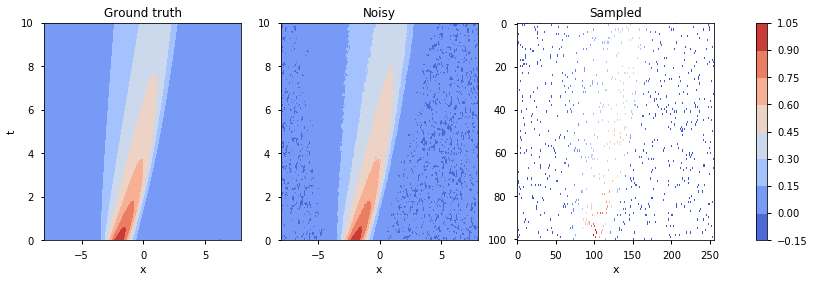

In [23]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap='coolwarm')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap='coolwarm')
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap='coolwarm')
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

## Configuring DeepMoD

We now setup the options for DeepMoD. The setup requires the dimensions of the neural network, a library function and some args for the library function:

In [24]:
config = {'input_dim': 2, 'hidden_dim': 20, 'layers': 5, 'output_dim': 1, 'library_function': library_basic, 'library_args':{'poly_order': 2, 'diff_order': 2}}

Now we instantiate the model:

In [25]:
model = DeepMod(config)

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
X_input = create_deriv_data(X_train, config['library_args']['diff_order'])

In [27]:
model.train(X_input, y_train, optimizer, 2000, type='deepmod')

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       2000    100.00%               0s   2.35e-04   1.51e-04   6.02e-05   2.39e-05 
[Parameter containing:
tensor([[-0.1541],
        [ 0.0750],
        [-0.4138],
        [ 0.1800]], requires_grad=True)]
[tensor([1, 2, 4, 6])]

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       2000    100.00%               0s   9.31e-04   1.51e-04   7.80e-04   0.00e+00 

Now that DeepMoD has converged, it has found the following numbers:

In [28]:
print('Final result:')
print(model.coeff_vector_list[0], model.sparsity_mask_list)

Final result:
Parameter containing:
tensor([[-0.1541],
        [ 0.0750],
        [-0.4138],
        [ 0.1800]], requires_grad=True) [tensor([1, 2, 4, 6])]


We can put that into a slightly friendlier format by defining which terms our library used:

In [29]:
deriv_list = [['', 'u_x', 'u_xx']]
poly_list = [['', 'u', 'u^2']]

In [30]:
terms = terms_definition(poly_list, deriv_list)

In [31]:
terms

['', 'u_x', 'u_xx', 'u', 'uu_x', 'uu_xx', 'u^2', 'u^2u_x', 'u^2u_xx']

In [32]:
def print_eq(coeff_vector, sparsity_mask, terms):
    for coeff, term in zip(coeff_vector, sparsity_mask):
        print(coeff.item(), terms[term])

In [33]:
print_eq(model.coeff_vector_list[0].detach().cpu().numpy(), model.sparsity_mask_list[0].cpu().numpy(), terms)

-0.15407651662826538 u_x
0.07501989603042603 u_xx
-0.41382771730422974 uu_x
0.1800319105386734 u^2


Which is the Burgers equation :-).

# Other options

We have a few other options, most notably training the mse or a single deepmod cycle (i.e. mse + reg + l1, but not thresholding):

In [21]:
model.train(X_input, y_train, optimizer, 1000, type='mse')

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       1000    100.00%               0s   8.28e-05   8.28e-05   0.00e+00   0.00e+00 

In [22]:
model.train(X_input, y_train, optimizer, 1000, type='single_cycle')

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
       1000    100.00%               0s   2.65e-04   8.28e-05   1.70e-04   1.25e-05 